In [1]:
import glob
import json
import math
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


import numpy as np
import cv2
from cv2 import aruco
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pprint as pp

In [2]:
parameter_dir=r"C:\Users\ZAIO\dev\python_aruco_marker_visualization\camera_parameters"

#load xml file
camera_parameters = {}
# camera_idxs = ["18284509","18284511","18284512"]
camera_idxs = ["18284509"]

parameter_types = ["CameraMatrix","Intrinsics","Distortion"]

for camera_idx in camera_idxs:
    fileToLoad = os.path.join(parameter_dir,camera_idx+".xml")
    fs = cv2.FileStorage(fileToLoad, cv2.FILE_STORAGE_READ)
    _camera_parameter = {}
    for parameter_type in parameter_types:
        _camera_parameter[parameter_type] = fs.getNode(parameter_type).mat()
        camera_parameters[camera_idx] = _camera_parameter

#3d points to image (2nd image)
extri = [0]*3
intri  = [0]*3
dist = [0]*3

for i in range(len(camera_idxs)):
    rotation_matrix = camera_parameters[camera_idxs[i]][parameter_types[0]][:,0:3]
    rvec,_ = cv2.Rodrigues(rotation_matrix)
    tvec = camera_parameters[camera_idxs[i]][parameter_types[0]][:,3]
    
    extri[i] = camera_parameters[camera_idxs[i]][parameter_types[0]]
    intri[i] = camera_parameters[camera_idxs[i]][parameter_types[1]]
    dist[i] = camera_parameters[camera_idxs[i]][parameter_types[2]]
    
camera_index = 0

mtx = camera_parameters[camera_idxs[camera_index]][parameter_types[1]]
dist = camera_parameters[camera_idxs[camera_index]][parameter_types[2]]
pp.pprint(mtx)
pp.pprint(dist)

array([[1.59106837e+03, 0.00000000e+00, 6.34909755e+02],
       [0.00000000e+00, 1.59838858e+03, 5.01707782e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
array([[ 1.36945721e-02],
       [-1.94217874e-01],
       [ 2.42371839e-04],
       [ 6.03200809e-04],
       [-4.39915075e+00],
       [ 3.17459364e-03],
       [-3.13005525e-01],
       [-3.73922900e+00]])


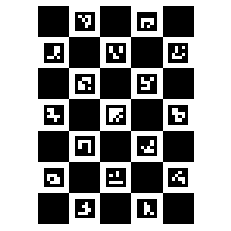

In [3]:
# create  Charuco board
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
parameters =  aruco.DetectorParameters_create()
board = aruco.CharucoBoard_create(5, 7, 0.14, 0.088, aruco_dict)
imboard = board.draw((2000, 2000))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()

In [18]:
length_of_axis = 0.09
markerLength = 0.18

#detect Charucoboad with calibration pose

def charucoDetector(image_data):
    frame  = cv2.imread(image_data,cv2.IMREAD_UNCHANGED)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    markerCorners, markerIds, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    imaxis = aruco.drawDetectedMarkers(frame.copy(), markerCorners, markerIds)
    retval,charucoCorners,charucoIds= cv2.aruco.interpolateCornersCharuco(markerCorners,markerIds,gray,board)
    imaxis_charuco = cv2.aruco.drawDetectedCornersCharuco(imaxis,charucoCorners,charucoIds,(0,0,255))
    
    rvecs, tvecs, _objPoints=cv2.aruco.estimatePoseSingleMarkers(markerCorners, markerLength, mtx, dist)
    retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charucoCorners, charucoIds, board, mtx, dist,rvecs,tvecs)
    imaxis_final= cv2.aruco.drawAxis(imaxis_charuco,mtx, dist, rvec,tvec,length = 0.18)
    
    print(str(len(rvecs)) + "/18")
    
    # plt.figure(figsize=(15,15))
    # plt.imshow(imaxis_charuco)
    # plt.show()
    detected_num = len(rvecs)
    print("rvec")
    print(rvec)
    print("tvec")
    print(tvec)
    return rvec,tvec,detected_num

In [19]:
rvec_0,tvec_0, _ = charucoDetector(r"I:\20200819_Result2\selected\000000000030_rendered.png")
rvec_X,tvec_X, _ = charucoDetector(r"I:\20200819_Result2\selected\000000000062_rendered.png")
rvec_Y,tvec_Y, _ = charucoDetector(r"I:\20200819_Result2\selected\000000000017_rendered.png")

16/18
rvec
[[ 0.320882  ]
 [ 2.4736542 ]
 [-1.78582012]]
tvec
[[0.4345527 ]
 [0.71765216]
 [5.28290166]]
11/18
rvec
[[ 1.60143948]
 [ 1.21528165]
 [-0.9324047 ]]
tvec
[[-0.66388062]
 [ 0.8286575 ]
 [ 5.14498391]]
11/18
rvec
[[ 1.24113416]
 [-1.66466819]
 [ 1.13303323]]
tvec
[[0.60944327]
 [0.90569718]
 [4.68999267]]


In [43]:
floor_X = np.array(tvec_X-tvec_0).flatten()
floor_Y = np.array(tvec_Y-tvec_0).flatten()
floor_Z = np.cross(floor_X,floor_Y)
norm_floor_Z = floor_Z/np.linalg.norm(floor_Z)

print(norm_floor_Z)

[-0.05591049 -0.94684624 -0.3167905 ]


In [47]:
print(rvec_0/np.linalg.norm(rvec_0))
print(rvec_X/np.linalg.norm(rvec_X))
print(rvec_Y/np.linalg.norm(rvec_Y))

[[ 0.10459852]
 [ 0.80634179]
 [-0.5821272 ]]
[[ 0.72265356]
 [ 0.54839887]
 [-0.42074994]]
[[ 0.52469521]
 [-0.70374618]
 [ 0.47899504]]


In [53]:
rtx_0, _ = cv2.Rodrigues(rvec_0)
print(rtx_0)

ValueError: too many values to unpack (expected 1)

In [63]:
vec_floor_x = [0,-1,0]
rtx_0_inv = np.linalg.inv(rtx_0)
np.matmul(rtx_0_inv,vec_floor_x)
print(np.matmul(rtx_0_inv,vec_floor_x))

[-0.12550711 -0.30132746  0.9452247 ]
